# Кластеризация
__Суммарное количество баллов: 10__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [1]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
# import cv2
from collections import deque, Counter

In [2]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

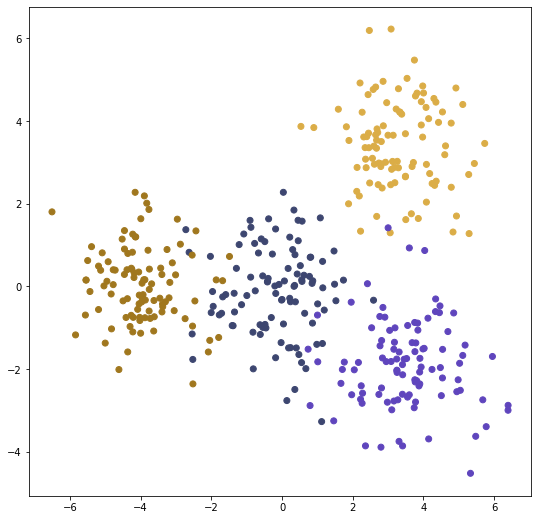

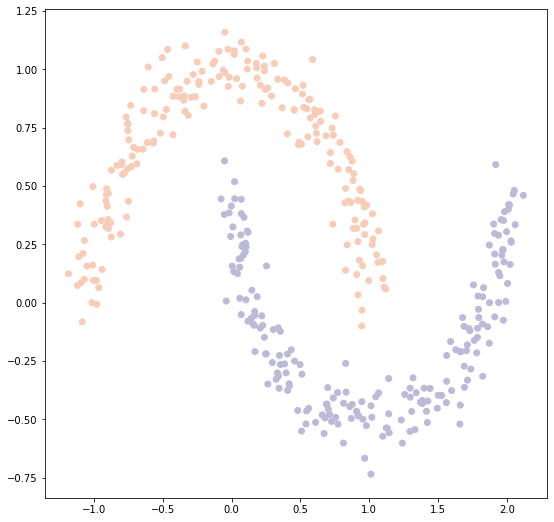

In [3]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (2 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++


In [4]:
def closest_center(x, centers):
    distances = np.array([np.linalg.norm(c-x) for c in centers])
    return np.argmin(distances)

In [5]:
class KMeans:
    def __init__(self, n_clusters, init="random", max_iter=100):
        self.max_iter = max_iter
        self.n_clusters = n_clusters
        self.init_method = init
        
    def random_centroids(self, X):
        left, right = np.amin(X, axis=0), np.amax(X, axis=0)
        return np.array([np.random.rand(len(left)) * (right - left) + left for _ in range(self.n_clusters)])
    
    def sample_centroids(self, X):
        idx = np.random.randint(len(X), size=self.n_clusters)
        return X[idx, :]
    
    def kmpp_centroids(self, X):
        idx = np.random.randint(len(X), size=1)
        centroids = [X[idx, :], ]
        for _ in range(self.n_clusters - 1):
            distances = np.array([min([np.linalg.norm(c-x) for c in centroids]) for x in X])
            p = distances ** 2
            new_idx = np.random.choice(len(X), p=p / np.sum(p))
            centroids.append(X[new_idx, :])
        return centroids
        
    def fit(self, X, y=None):
        if self.init_method == 'random':
            centroids = self.random_centroids(X)
        elif self.init_method == 'sample':
            centroids = self.sample_centroids(X)
        else:
            centroids = self.kmpp_centroids(X)
        
        y = y or np.zeros(len(X))
        for i in range(self.max_iter):
            # assign datapoints to closest center
            for i, x in enumerate(X):
                y[i] = closest_center(x, centroids)
            # shift cluster center to center of mass 
            centroids = np.array([np.mean(X[y == i], axis=0) for i in range(self.n_clusters)])
        self.centroids = centroids
        
        
    def predict(self, X):
        y = np.array([closest_center(x, self.centroids) for x in X])
        return y
        

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

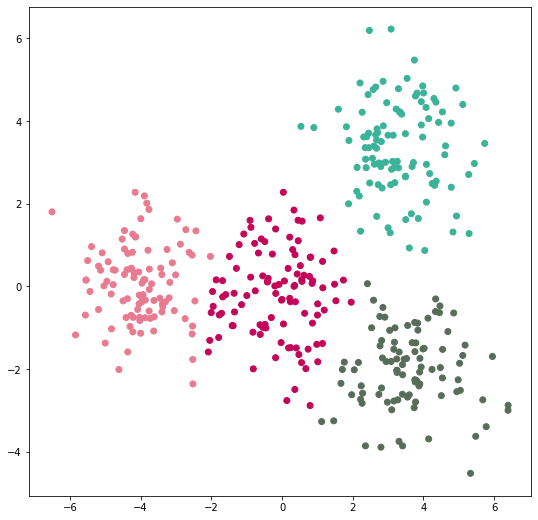

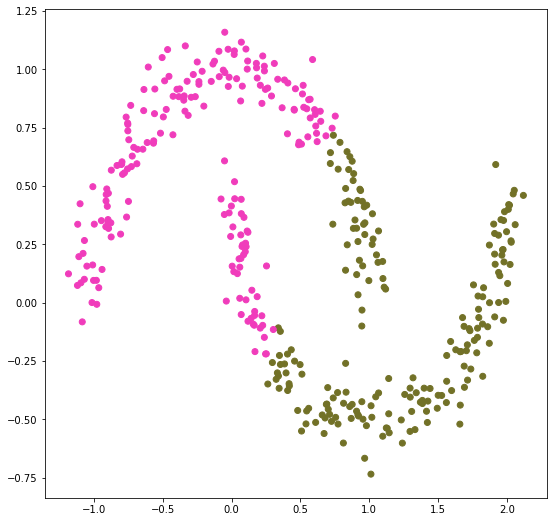

In [6]:
kmeans = KMeans(n_clusters=4, init='k-means++')
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (4 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [7]:
def merge_clusters(neighbour_idxs, y):
    cluster_ids = [y[x] for x in neighbour_idxs]
    if cluster_ids:
        new_label = min(cluster_ids)
        return np.array([new_label if x in cluster_ids else x for x in y])
    else: 
        return y

In [8]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean", highlight_noise=False):
        self.metric = metric
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.highlight_noise = highlight_noise
        
    def fit_predict(self, X, y=None):
        kdtree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        core_samples = kdtree.query_radius(X, r=self.eps, count_only=True) >= self.min_samples
        y = np.arange(len(X))
        neighbours = kdtree.query_radius(X, r=self.eps)
        for core, neighbour_idxs in zip(core_samples, neighbours):
            if core:
                y = merge_clusters(neighbour_idxs, y)   
       
        y_unique = Counter(y)
        classes = list(filter(lambda x: y_unique[x] >= self.min_samples, y_unique))
        n_classes = len(classes)
        converter = dict(zip(classes, range(n_classes)))
        
        if self.highlight_noise:
            y = np.array([converter[x] if x in classes else n_classes for x in y])
                    
        else:
            for i, label in enumerate(y):
                if label not in classes:
                    dist, ind = kdtree.query(X[i].reshape(1, -1), k=self.min_samples * 2)
                    closest = Counter([y[x] for x in ind[0]])
                    y[i] = max(closest, key=lambda x: closest[x])
            y = np.array([converter[x] for x in y])
        return y
        

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

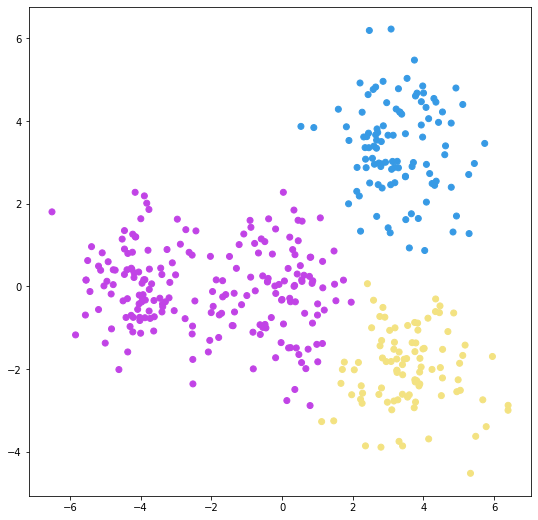

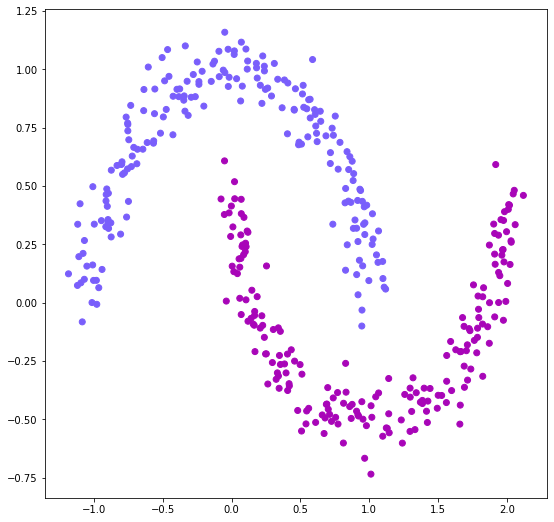

In [9]:
dbscan = DBScan(eps=0.6, min_samples=5, metric="euclidean")
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)
# 
dbscan = DBScan(eps=0.2, min_samples=5, metric="manhattan")
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (4 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [10]:
class AgglomertiveClustering:
    def __init__(self, n_clusters=16, linkage="average"):
        self.n_clusters = n_clusters
        self.linkage = linkage
        if linkage == "average":
            self.get_distance = self.get_average_distance
        elif linkage == "single":
            self.get_distance = self.get_single_distance
        else:
            self.get_distance = self.get_complete_distance
        
    def get_average_distance(self, cluster1, cluster2, pair_distance):
        total_dist = 0
        for i in cluster1:
            for j in cluster2:
                total_dist += pair_distance[min(i, j), max(i, j)]

        return total_dist / len(cluster1) / len(cluster2)
    
    def get_single_distance(self, cluster1, cluster2, pair_distance):
        all_dist = []
        for i in cluster1:
            for j in cluster2:
                all_dist.append(pair_distance[min(i, j), max(i, j)])

        return min(all_dist)
    
    def get_complete_distance(self, cluster1, cluster2, pair_distance):
        all_dist = []
        for i in cluster1:
            for j in cluster2:
                all_dist.append(pair_distance[min(i, j), max(i, j)])

        return max(all_dist)
    
    def fit_predict(self, X, y=None):
        n_points = len(X)
        
        # calculate distaces between points
        point_distance = np.tril(np.full((n_points, n_points), np.inf))
        for i in range(n_points):
            for j in range(i, n_points):
                point_distance[i, j] += np.linalg.norm(X[i]-X[j])
        
        clusters = [[x] for x in range(n_points)]
        cluster_distance = copy.deepcopy(point_distance)
        for n in range(n_points, self.n_clusters, -1):
            # find two closest clusters acording to linkage type
            flat_index = np.argmin(cluster_distance)
            i, j = flat_index // n, flat_index % n
            
            # merge them
            clusters[i].extend(clusters.pop(j))
            
            # remove distances to clustered objects
            for axis in (0, 1):
                cluster_distance = np.delete(cluster_distance, (j, ), axis=axis)
            
            # recalculate distances
            for k in range(n - 1):
                if k != i:
                    cluster_distance[min(i, k), max(i, k)] = self.get_distance(clusters[i], clusters[k], point_distance)
            
        y = np.arange(n_points)
        for label, clust in enumerate(clusters):
            for idx in clust:
                y[idx] = label
        return y

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

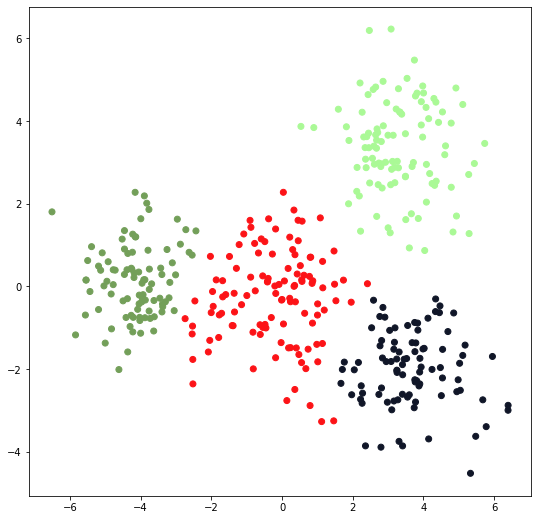

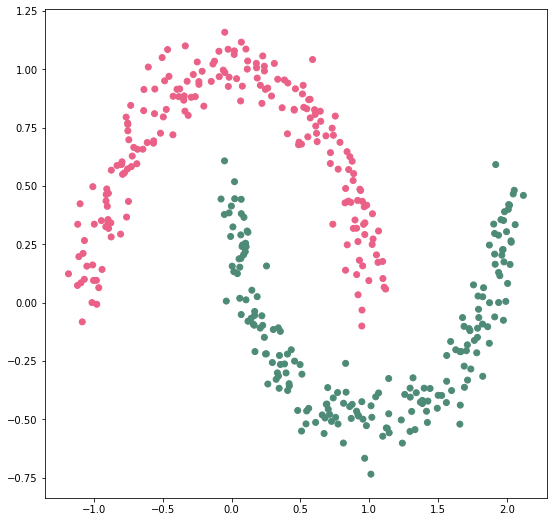

In [11]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage="single")
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)